Time steps: 100%|██████████| 200000/200000 [22:08:49<00:00,  2.51it/s]        


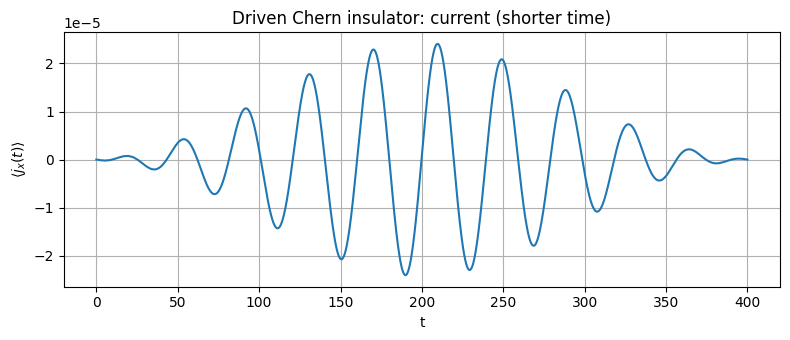

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pauli matrices
sigma_x = np.array([[0,1],[1,0]], dtype=complex)
sigma_y = np.array([[0,-1j],[1j,0]], dtype=complex)
sigma_z = np.array([[1,0],[0,-1]], dtype=complex)
identity2 = np.eye(2, dtype=complex)

# Chern insulator Hamiltonian
def H0_k(kx, ky, Delta):
    dx = np.sin(kx)
    dy = np.sin(ky)
    dz = Delta + np.cos(kx) + np.cos(ky)
    return dx*sigma_x + dy*sigma_y + dz*sigma_z

# Hamiltonian derivative for current
def dH0_dkx(kx, ky):
    return np.cos(kx)*sigma_x - np.sin(kx)*sigma_z

# Pumping field
def A_field(t, A0=0.01, Nc=10, omega0=None):
    if omega0 is None:
        omega0 = np.pi/(2*Nc)
    return A0 * np.sin(omega0*t) * (np.sin(omega0*t/(2*Nc)))**2

# Analytic 2x2 exponential
def analytic_2x2_exp(H, dt):
    h0 = 0.5*np.trace(H)
    Htr = H - h0*identity2
    E2 = 0.5*np.trace(Htr @ Htr)
    E = np.sqrt(np.real(E2))
    if E < 1e-12:
        return np.exp(-1j*h0*dt)*(identity2 - 1j*Htr*dt)
    cos_term = np.cos(E*dt)
    sin_term = np.sin(E*dt)
    Utr = cos_term*identity2 - 1j*(sin_term/E)*Htr
    return np.exp(-1j*h0*dt)*Utr

# Precompute eigenvectors and eigenvalues
def precompute_grid(Nkx=41, Nky=41, Delta=1.0):
    kx_vals = np.linspace(-np.pi, np.pi, Nkx, endpoint=False)
    ky_vals = np.linspace(-np.pi, np.pi, Nky, endpoint=False)
    U_grid = np.zeros((Nkx,Nky,2,2), dtype=complex)
    Eval_grid = np.zeros((Nkx,Nky,2), dtype=float)
    
    for ix, kx in enumerate(kx_vals):
        for iy, ky in enumerate(ky_vals):
            H = H0_k(kx, ky, Delta)
            ev, evecs = np.linalg.eigh(H)
            U_grid[ix,iy] = evecs
            Eval_grid[ix,iy] = ev
    return kx_vals, ky_vals, U_grid, Eval_grid

# Time evolution
def run_simulation(Delta=1.0, A0=0.01, Nc=10, Nkx=41, Nky=41, dt=0.002, Tfactor=1.0):
    kx_vals, ky_vals, U_grid, Eval_grid = precompute_grid(Nkx, Nky, Delta)
    omega0 = np.pi/(2*Nc)
    T = 2*np.pi*Nc/omega0 * Tfactor
    Nt = int(np.round(T/dt))
    time = np.linspace(0,T,Nt)
    j_t = np.zeros(Nt, dtype=float)
    
    # Initial density matrix in eigenbasis (lower band occupied)
    rho0 = np.array([[1.0,0],[0,0]], dtype=complex)
    
    for it, t in enumerate(tqdm(time, desc="Time steps")):
        Ax = A_field(t, A0=A0, Nc=Nc, omega0=omega0)
        j_sum = 0.0
        for ix, kx in enumerate(kx_vals):
            for iy, ky in enumerate(ky_vals):
                U = U_grid[ix,iy]
                Hshift = H0_k(kx-Ax, ky, Delta)
                dHshift = dH0_dkx(kx-Ax, ky)
                # Rotate into eigenbasis
                Htilde = U.conj().T @ Hshift @ U
                dHtilde = U.conj().T @ dHshift @ U
                jtilde = dHtilde
                # Time evolution
                U_evol = analytic_2x2_exp(Htilde, dt)
                try:
                    rho_grid
                except NameError:
                    rho_grid = np.tile(rho0, (Nkx,Nky,1,1)).astype(complex)
                rho_grid[ix,iy] = U_evol @ rho_grid[ix,iy] @ U_evol.conj().T
                j_sum += np.trace(jtilde @ rho_grid[ix,iy]).real
        j_t[it] = j_sum / (Nkx*Nky)  # simple average over BZ
    
    return time, j_t

# Run the simulation 
time, j_t = run_simulation(Delta=1.0, A0=0.01, Nc=10, Nkx=41, Nky=41, dt=0.002, Tfactor=1.0)

# Plot current
plt.figure(figsize=(8,3.5))
plt.plot(time, j_t)
plt.xlabel('t')
plt.ylabel(r'$\langle j_x(t)\rangle$')
plt.title('Driven Chern insulator: current')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

sx = np.array([[0,1],[1,0]], complex)
sy = np.array([[0,-1j],[1j,0]], complex)
sz = np.array([[1,0],[0,-1]], complex)

def H(kx, ky, Delta):
    dx, dy, dz = np.sin(kx), np.sin(ky), Delta + np.cos(kx) + np.cos(ky)
    return dx*sx + dy*sy + dz*sz

def chern_number(N=81, Delta=1):
    kx = np.linspace(-np.pi, np.pi, N, endpoint=False)
    ky = np.linspace(-np.pi, np.pi, N, endpoint=False)
    F = 0.0
    for i in range(N):
        for j in range(N):
            k = [(kx[i], ky[j]),
                 (kx[(i+1)%N], ky[j]),
                 (kx[(i+1)%N], ky[(j+1)%N]),
                 (kx[i], ky[(j+1)%N])]
            u = [np.linalg.eigh(H(*kk, Delta))[1][:,0] for kk in k]
            U12 = np.vdot(u[0], u[1])
            U23 = np.vdot(u[1], u[2])
            U34 = np.vdot(u[2], u[3])
            U41 = np.vdot(u[3], u[0])
            F += np.angle(U12 * U23 * U34 * U41)
    return F / (2 * np.pi)

print("Chern number (Δ=1):", round(chern_number(81, 1), 3))


Chern number (Δ=1): 1.0


Sim Δ=1.0, evolve_fixed_basis=True: 100%|██████████| 200001/200001 [27:15:14<00:00,  2.04it/s]        
C:\Users\zimme\AppData\Local\Temp\ipykernel_24908\3885598044.py:170: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  jy_avg = np.trapz(jy_cycle, t_cycle) / (t_cycle[-1] - t_cycle[0])
C:\Users\zimme\AppData\Local\Temp\ipykernel_24908\3885598044.py:171: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Q = np.trapz(jy_cycle, t_cycle)  # integrated pumped charge over that last cycle
Sim Δ=3.0, evolve_fixed_basis=True: 100%|██████████| 200001/200001 [16:55:19<00:00,  3.28it/s]        



=== Results (averaged over final pump cycle) ===
Delta=1.0 (topological):  <j_y> = -1.422559e-08,  Pumped Q (one cycle) = -5.690237e-07
Delta=3.0 (trivial):      <j_y> = 5.604249e-10,  Pumped Q (one cycle) = 2.241700e-08


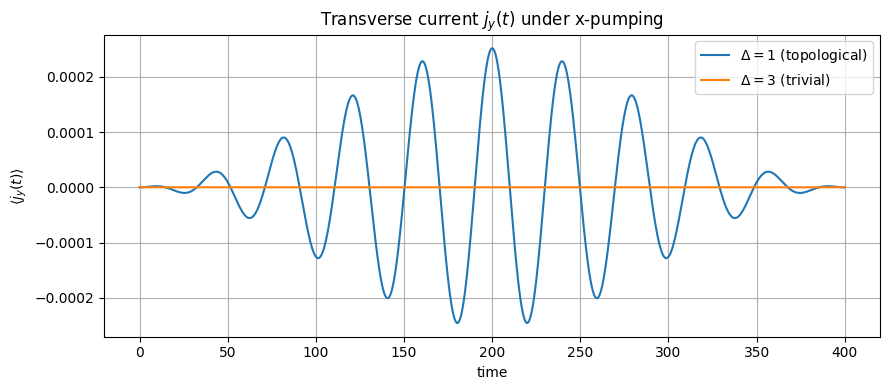

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity2 = np.eye(2, dtype=complex)

#Model Hamiltonian and derivatives
def H0_k(kx, ky, Delta):
    dx = np.sin(kx)
    dy = np.sin(ky)
    dz = Delta + np.cos(kx) + np.cos(ky)
    return dx*sigma_x + dy*sigma_y + dz*sigma_z

def dH0_dkx(kx, ky):
    # d/dkx[ sin(kx) sigma_x + cos(kx) sigma_z ] = cos(kx) sigma_x - sin(kx) sigma_z
    return np.cos(kx)*sigma_x - np.sin(kx)*sigma_z

def dH0_dky(kx, ky):
    # d/dky[ sin(ky) sigma_y + cos(ky) sigma_z ] = cos(ky) sigma_y - sin(ky) sigma_z
    return np.cos(ky)*sigma_y - np.sin(ky)*sigma_z

#Pumping (A_x(t))
def A_field(t, A0=0.01, Nc=10, omega0=None):
    if omega0 is None:
        omega0 = np.pi/(2*Nc)
    return A0 * np.sin(omega0*t) * (np.sin(omega0*t/(2*Nc)))**2

def analytic_2x2_exp(H, dt):
    # H is 2x2 Hermitian (complex)
    # factor out trace
    h0 = 0.5*np.trace(H)
    Htr = H - h0*identity2
    E2 = 0.5*np.trace(Htr @ Htr)
    E = np.sqrt(np.real(E2))
    if E < 1e-12:
        # small-angle series expansion
        return np.exp(-1j*h0*dt)*(identity2 - 1j*Htr*dt)
    cos_term = np.cos(E*dt)
    sin_term = np.sin(E*dt)
    Utr = cos_term*identity2 - 1j*(sin_term/E)*Htr
    return np.exp(-1j*h0*dt)*Utr

#Precompute eigenvectors for the static H0(kx,ky,Delta)
def precompute_grid(Nkx=41, Nky=41, Delta=1.0):
    kx_vals = np.linspace(-np.pi, np.pi, Nkx, endpoint=False)
    ky_vals = np.linspace(-np.pi, np.pi, Nky, endpoint=False)
    U_grid = np.zeros((Nkx, Nky, 2, 2), dtype=complex)
    Eval_grid = np.zeros((Nkx, Nky, 2), dtype=float)
    for ix, kx in enumerate(kx_vals):
        for iy, ky in enumerate(ky_vals):
            H = H0_k(kx, ky, Delta)
            ev, evecs = np.linalg.eigh(H)
            U_grid[ix, iy] = evecs
            Eval_grid[ix, iy] = ev
    return kx_vals, ky_vals, U_grid, Eval_grid

#Time evolution simulation; returns time, jx_t, jy_t
def run_simulation(
    Delta=1.0,
    A0=0.01,
    Nc=10,
    Nkx=41,
    Nky=41,
    dt=0.002,
    Tfactor=1.0,
    evolve_in_fixed_basis=True
):
    #precompute eigenvectors of H0 (static band basis)
    kx_vals, ky_vals, U_grid, Eval_grid = precompute_grid(Nkx, Nky, Delta)

    omega0 = np.pi/(2*Nc)
    #total time: Nc cycles of the basic sin(omega0 t) 
    T_total = 2.0*np.pi*Nc/omega0 * Tfactor

    #ensure consistent dt: use arange so steps equal dt exactly
    Nt = int(np.floor(T_total/dt)) + 1
    time = np.arange(Nt) * dt

    #storage for currents
    jx_t = np.zeros(Nt, dtype=float)
    jy_t = np.zeros(Nt, dtype=float)

    #initial density matrix in eigenbasis (lower band occupied)
    rho0 = np.array([[1.0, 0.0], [0.0, 0.0]], dtype=complex)
    rho_grid = np.tile(rho0, (Nkx, Nky, 1, 1)).astype(complex)

    #main time loop
    for it, t in enumerate(tqdm(time, desc=f"Sim Δ={Delta}, evolve_fixed_basis={evolve_in_fixed_basis}")):
        Ax = A_field(t, A0=A0, Nc=Nc, omega0=omega0)
        jx_sum = 0.0
        jy_sum = 0.0

        for ix, kx in enumerate(kx_vals):
            for iy, ky in enumerate(ky_vals):
                U = U_grid[ix, iy]  #eigenvectors of H0(kx,ky;Delta)
                kx_shift = kx - Ax
                #Hamiltonian and derivatives at shifted momentum (Peierls substitution)
                Hshift = H0_k(kx_shift, ky, Delta)
                dHx   = dH0_dkx(kx_shift, ky)
                dHy   = dH0_dky(kx_shift, ky)

                if evolve_in_fixed_basis:
                    #rotate Hshift and derivatives into the fixed precomputed basis U
                    Htilde  = U.conj().T @ Hshift @ U
                    dHx_til = U.conj().T @ dHx @ U
                    dHy_til = U.conj().T @ dHy @ U
                    #time-evolution operator in that basis
                    U_evol = analytic_2x2_exp(Htilde, dt)
                    #evolve rho (stored in the same fixed basis)
                    rho_grid[ix, iy] = U_evol @ rho_grid[ix, iy] @ U_evol.conj().T
                    #currents computed using rotated derivative operators and rho in same basis
                    jx_sum += np.trace(dHx_til @ rho_grid[ix, iy]).real
                    jy_sum += np.trace(dHy_til @ rho_grid[ix, iy]).real
                else:
                    if it == 0:
                        ev, evecs = np.linalg.eigh(H0_k(kx, ky, Delta))
                        # lower band eigenvector (first column) for H0(kx,ky)
                        psi_lower = evecs[:, 0]
                        rho_lab = np.outer(psi_lower, psi_lower.conj())
                        # store a lab-basis rho grid separately
                        if ix == 0 and iy == 0:
                            rho_lab_grid = np.zeros((Nkx, Nky, 2, 2), dtype=complex)
                        rho_lab_grid[ix, iy] = rho_lab

                    U_evol_lab = analytic_2x2_exp(Hshift, dt)
                    rho_lab_grid[ix, iy] = U_evol_lab @ rho_lab_grid[ix, iy] @ U_evol_lab.conj().T

                    jx_sum += np.trace(dHx @ rho_lab_grid[ix, iy]).real
                    jy_sum += np.trace(dHy @ rho_lab_grid[ix, iy]).real

        # average over BZ
        jx_t[it] = jx_sum / (Nkx * Nky)
        jy_t[it] = jy_sum / (Nkx * Nky)

    return time, jx_t, jy_t

#Compute cycle-averaged j_y and pumped charge per cycle
def cycle_average_and_charge(time, jy_t, omega0):
    #pumping fundamental period
    Tc = 2.0*np.pi / omega0
    t_end = time[-1]
    t_start = t_end - Tc
    if t_start < time[0]:
        jy_avg = np.trapz(jy_t, time) / (time[-1] - time[0])
        Q = np.trapz(jy_t, time)  #total pumped "charge" over whole time
        return jy_avg, Q, Tc
    #find indices within [t_start, t_end]
    mask = (time >= t_start) & (time <= t_end)
    jy_cycle = jy_t[mask]
    t_cycle = time[mask]
    jy_avg = np.trapz(jy_cycle, t_cycle) / (t_cycle[-1] - t_cycle[0])
    Q = np.trapz(jy_cycle, t_cycle)  #integrated pumped charge over that last cycle
    return jy_avg, Q, Tc

#Running the Delta=1 (topological) and Delta=3 (trivial) simulations
if __name__ == "__main__":
    A0 = 0.01
    Nc = 10
    Nkx = 41
    Nky = 41
    dt = 0.002
    Tfactor = 1.0
    evolve_in_fixed_basis = True 

    omega0 = np.pi/(2*Nc)

    #Topological Δ = 1
    time1, jx1, jy1 = run_simulation(
        Delta=1.0, A0=A0, Nc=Nc, Nkx=Nkx, Nky=Nky, dt=dt,
        Tfactor=Tfactor, evolve_in_fixed_basis=evolve_in_fixed_basis
    )
    jy_avg_top, Q_top, Tc = cycle_average_and_charge(time1, jy1, omega0)

    #Trivial Δ = 3
    time2, jx2, jy2 = run_simulation(
        Delta=3.0, A0=A0, Nc=Nc, Nkx=Nkx, Nky=Nky, dt=dt,
        Tfactor=Tfactor, evolve_in_fixed_basis=evolve_in_fixed_basis
    )
    jy_avg_tri, Q_tri, _ = cycle_average_and_charge(time2, jy2, omega0)

    #Print results
    print("\n=== Results (averaged over final pump cycle) ===")
    print(f"Delta=1.0 (topological):  <j_y> = {jy_avg_top:.6e},  Pumped Q (one cycle) = {Q_top:.6e}")
    print(f"Delta=3.0 (trivial):      <j_y> = {jy_avg_tri:.6e},  Pumped Q (one cycle) = {Q_tri:.6e}")

    #Plot j_y comparison
    plt.figure(figsize=(9,4))
    plt.plot(time1, jy1, label=r'$\Delta=1$ (topological)')
    plt.plot(time2, jy2, label=r'$\Delta=3$ (trivial)')
    plt.xlabel('time')
    plt.ylabel(r'$\langle j_y(t)\rangle$')
    plt.title('Transverse current $j_y(t)$ under x-pumping')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
